---

<p> Segunda Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Francisco Vilca Gamarra 

Repositorio alojado en [GitHub](https://github.com/vilcagamarracf/Inv_arroz_METRIC) 

Marzo, 2022

---

# Balance de Energía Superficial - Modelo METRIC

**Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)**

Descripción:
- METRIC es un modelo de procesamiento de imágenes para calcular la ET como residuo del balance energético de la superficie.
- METRIC fue desarrollado por la Universidad de Idaho para su aplicación a imágenes de satélite Landsat con el fin de maximizar la resolución del producto ET (30 m).
- METRIC utiliza como base el proceso pionero de balance energético SEBAL desarrollado en los Países Bajos por Bastiaanssen et al..

Aplicación de referencia:
- [geeSEBAL en GitHub](https://github.com/et-brasil/geeSEBAL/blob/a8242225bcb184329372ee0dbdc411d1e9d5c766/JavaScrpit/tools.js)

## Inicio

In [1]:
# ------------------------------------------------
# Importando librerías utilizadas
# ------------------------------------------------

import ee          # Earth Engine Python API
ee.Initialize()

import os
import numpy as np
import math

import pandas as pd
pd.set_option('display.max_columns', 30) # Visualizar máximo de 30 columnas

import geemap
import geemap.colormaps as cmp    # Paletas para visualización de imágenes

from geemap import cartoee        # Elaboración de gráficas
import cartopy.crs as ccrs        # Importar sistema de coordenadas para gráficas

from pprint import pprint
import matplotlib.pyplot as plt

# Funciones en archivo Funciones.py
from funciones import *

In [37]:
# ------------------------------------------------------------------------------------------------
# Pruebas: En caso de realizar alguna edición al archivo 'funciones.py' realizar lo siguiente:
# ------------------------------------------------------------------------------------------------

import importlib
import sys

importlib.reload(sys.modules['funciones']) # Importa las funciones del archivo con las modificaciones aplicadas
from funciones import *

In [2]:
# ------------------------------------------------
# Importando áreas de estudio
# ------------------------------------------------

# Importar asset público: Distrito de Ferreñafe
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', 'FERREÑAFE')
roi = dist_fcol.geometry().bounds()   # ee.Geometry tipo caja

# Importar shapefile de Áreas voladas (archivo en local)
ruta_ferrenafe = r'input/Ferreñafe_areas_2.shp'

# Lectura como FeatureCollection con geemap
predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 2, 2)  # Ver solo bordes, no relleno

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)  # Ver solo bordes, no relleno

# type(predios_agricolas) # Comprobación

# ------------------------------------------------
# Parámetros de visualización de mapas con geemap
# ------------------------------------------------

# Para imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061']  # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']  # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']  # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# -------------------------------------------------------
# Parámetros de visualización de gráficas con matplotlib
# -------------------------------------------------------

plt.rcParams['font.family'] = 'serif'  #'serif', 'Arial'  # default es 'sans-serif'
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 72

## Procesamiento

In [3]:
# =============================================================
# Inputs iniciales
# =============================================================

# 8 Imágenes Landsat seleccionadas
lista_ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113',  # 0 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129',  # 1 - 01/29 - l9 producia error en iteracion hasta bajar el ET
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310',  # 2 - 03/10 - l8 mayoria de superficie cubierta por arroz
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403',  # 3 - 04/03 - l9 <------
    'LANDSAT/LC09/C02/T1/LC09_010065_20220505',  # 4 - 05/05 - l9 <------
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521',  # 5 - 05/21 - l9 <------
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'   # 6 - 06/14 - l8
]

# DEM SRTM 
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores al área de estudio
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

In [4]:
# =============================================================
# Procesar las imagenes e incluirlos en una lista
# =============================================================
# Asignar método de estimación de LAI
# 0: Savi con l=0.1 
# 1: Savi con L=0.5 
# 2: Relación lineal NDVI - IAF: 2.1362*NDVI + 0.0869
# 3: Relación cuadrada NDVI - IAF : 2.3523*NDVI^2 - 1.9013*NDVI + 1.7714

lai_method = 1
albedo_method = '0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7'

HR = [
    82, # 0 '2022-01-13'
    81, # 1 '2022-01-29'
    83, # 2 '2022-03-10'
    72, # 3 '2022-04-03' # Sin dato
    70, # 4 '2022-05-05' # Sin dato 
    68, # 5 '2022-05-21' # Sin dato
    65  # 6 '2022-06-14'
]

# Lista en blanco que va a contener los resultados
lista_imgprocesadas = []

for index, img_id in enumerate(lista_ids):

    # Imagen Landsat mediante ID
    img_ee = ee.Image(img_id).clip(roi)
    
    # Procesar Radiación Neta (produce un dict)
    img_procesada_dict = getRadiacionNeta(img_ee, roi, dem, 
                                           lai_method, albedo_method, HR[index]) # roi: Ferreñafe

    # Recorte por regiones
    img_procesada_dict['img_productos'] = img_procesada_dict['img_productos'].clip(predios_agricolas)
    img_procesada_dict['img_toa'] = img_procesada_dict['img_toa'].clip(predios_bound)

    # Agregar a lista en blanco
    lista_imgprocesadas.append(img_procesada_dict)

    print(f"Productos y Rn de imagen {img_procesada_dict['fecha']} procesada! lai_method = {lai_method}")
    
n_imgs = len(lista_imgprocesadas)

Productos y Rn de imagen 2022-01-13 procesada! lai_method = 1
Productos y Rn de imagen 2022-01-29 procesada! lai_method = 1
Productos y Rn de imagen 2022-03-10 procesada! lai_method = 1
Productos y Rn de imagen 2022-04-03 procesada! lai_method = 1
Productos y Rn de imagen 2022-05-05 procesada! lai_method = 1
Productos y Rn de imagen 2022-05-21 procesada! lai_method = 1
Productos y Rn de imagen 2022-06-14 procesada! lai_method = 1


In [17]:
n_img = 0
img_rgb = lista_imgprocesadas[n_img]['img_toa'].clip(predios_bound)
img_rgb_sr = lista_imgprocesadas[n_img]['img_SR'].clip(predios_bound)
vis_params_sr = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.3, 'gamma':1.3}

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')
Map.addLayer(img_rgb_sr, vis_params_sr, 'img_rgb_sr')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
# Pixeles escogidos mediante comparación ndvi-temperatura
# Pixel frío
list_coords_pixf1 = [
    [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10   [-79.785803, -6.598076] mejor albedo
    [-79.78472, -6.598345],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10 Nuevo
    [-79.776047, -6.597519], # 4 '2022-05-05' n1: 40 n2: 10 Nuevo
    [-79.778976, -6.605092], # 5 '2022-05-21' n1: 50 n2: 10 Nuevo
    [-79.778737, -6.604828], # 6 '2022-06-14' n1: 50 n2: 5
]

# Pixel caliente
list_coords_pixc1 = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 40 n2: 97 
    [-79.778464, -6.605114], # 1 '2022-01-29' n1: 10 n2: 90
    [-79.777924, -6.604045], # 2 '2022-03-10' n1: 4 n2: 75 
    [-79.778463, -6.603747], # 3 '2022-04-03' n1: 10 n2: 80  
    [-79.784448, -6.598642], # 4 '2022-05-05' n1: 25 n2: 75  
    # [-79.784966, -6.602174], # 4 '2022-05-05'  Prueba en zona de temperaturas altas
    [-79.785537, -6.598398], # 5 '2022-05-21' n1: 30 n2: 80  
    [-79.784729, -6.595629], # 6 '2022-06-14' n1: 10 n2: 80 
]

# Pixeles escogidos mediante relación ndvi-albedo
# pixeles ndvi-albedo
list_coords_pixf = [
    [-79.775487, -6.601604], # 0 '2022-01-13' n1: 50 n2: 10
    [-79.785809, -6.598078], # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984], # 2 '2022-03-10' n1: 50 n2: 5  [-79.782536, -6.601574]
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10  [-79.782545, -6.601342]
    [-79.778744, -6.604585], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778718, -6.604593], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778739, -6.604574], # 6 '2022-06-14' n1: 50 n2: 5
]

# Pixeles ndvi-albedo 
list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.778464, -6.605114],  # 1 '2022-01-29' n1: 50 n2: 10 
    [-79.777924, -6.604045],  # 2 '2022-03-10' n1: 50 n2: 5 [-79.778736, -6.604317]
    [-79.778468, -6.603759],  # 3 '2022-04-03' n1: 80 n2: 10
    [-79.784448, -6.598642],#[-79.782006, -6.598379],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-79.785537, -6.598398],#[-79.78228, -6.596453],   # 5 '2022-05-21' n1: 50 n2: 10
    [-79.784729, -6.595629] #[-79.784462, -6.59621],   # 6 '2022-06-14' n1: 50 n2: 5
]

Procesando imagen 2022-01-13 lai_method = 1


coef a: 0.1567807206055259
coef b: -40.25844046018629



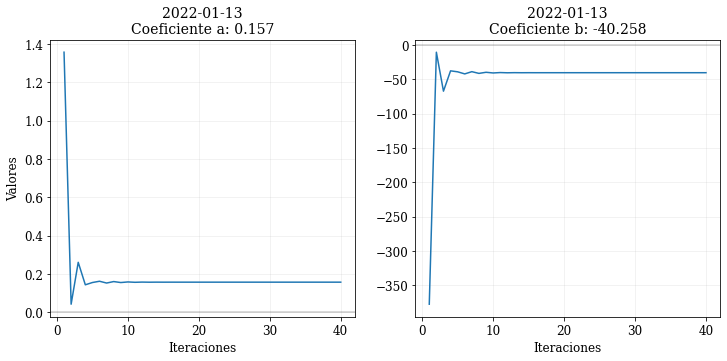


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,26.066006,0.638488,0.922158,0.185254,772.328767,82.277447,578.031242,251.982392,251.982392,8.867080
mean,20.426264,0.173787,0.045677,0.108548,686.110537,64.064258,468.905068,153.141211,153.173034,5.392227
median,19.968177,0.154227,0.000028,0.105683,687.494991,63.070315,463.461803,163.369398,162.708563,5.722259
min,17.866862,-0.147715,0.000000,0.060872,596.081181,51.980854,438.532979,-18.395543,0.000000,-0.648556
mode,19.529479,0.126766,0.000028,0.084238,696.470801,62.051227,457.485348,174.871352,174.470390,6.152229
stdDev,1.565740,0.121992,0.104066,0.026230,29.253303,4.916764,19.228541,48.402281,48.296241,1.700371


Procesando imagen 2022-01-29 lai_method = 1


coef a: 0.3850380275258874
coef b: -105.550145227151



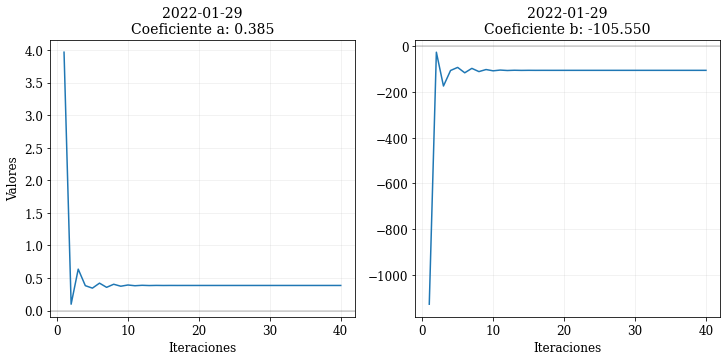


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,21.456889,0.758795,1.618656,0.193761,769.893507,67.892718,739.565771,193.848603,193.848603,6.802526
mean,17.434238,0.354347,0.204465,0.104572,700.364704,53.886749,558.682703,87.795252,90.919908,3.083336
median,17.483861,0.330639,0.120230,0.103044,701.358786,54.882403,553.464731,94.750471,94.443985,3.281462
min,15.572374,0.038919,0.000000,0.055416,619.664866,35.002628,503.306991,-149.830645,0.000000,-5.262059
mode,17.888105,0.345717,0.000559,0.093302,705.467406,55.141343,556.526980,109.200722,0.000000,3.840528
stdDev,0.771628,0.142571,0.251429,0.024198,24.264883,4.450407,34.148922,52.163786,43.431040,1.831731


Procesando imagen 2022-03-10 lai_method = 1


coef a: 0.9425598201612697
coef b: -276.1929618742096



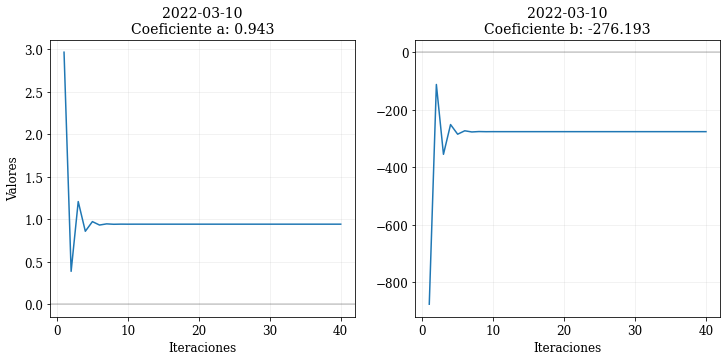


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,29.890949,0.813376,1.824356,0.188112,735.946369,89.601843,978.079605,150.695156,150.695156,5.336052
mean,25.692986,0.694646,1.004720,0.142750,639.913393,59.258295,581.853395,-1.198297,23.382071,-0.043360
median,25.549557,0.728591,1.051343,0.147895,636.586910,57.634188,573.010350,5.846776,5.534968,0.187526
min,24.946229,0.057734,0.000000,0.043448,585.680976,45.232677,478.497862,-455.178018,0.000000,-16.180024
mode,25.421164,0.759826,0.000000,0.154823,626.502063,53.881858,556.992630,38.186129,0.008478,1.435544
stdDev,0.605429,0.119466,0.351812,0.025800,24.677355,7.883641,55.343571,69.336945,31.124559,2.458254


Procesando imagen 2022-04-03 lai_method = 1


coef a: 0.8349872614552718
coef b: -234.67057199524376



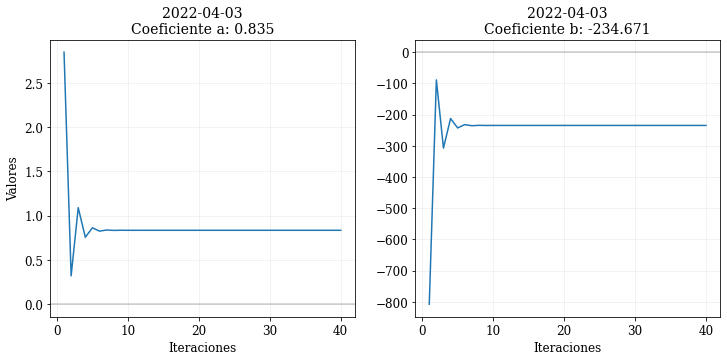


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,18.790636,0.768888,1.522038,0.195492,730.211959,58.651034,939.031649,124.772803,124.772803,4.369110
mean,14.590954,0.681405,1.053332,0.159901,659.103403,37.547639,632.600583,-11.044819,11.249687,-0.387715
median,14.420263,0.689477,1.066569,0.161898,657.726102,37.060840,622.977941,-3.081034,0.002593,-0.056782
min,13.893640,0.241967,0.048390,0.095135,613.085236,30.542937,535.955563,-358.724095,0.000000,-12.609258
mode,14.297902,0.689477,1.066569,0.169230,656.762671,37.311006,612.975586,-0.932450,0.002593,-0.056782
stdDev,0.583996,0.048727,0.198975,0.016002,17.552123,3.381303,45.039697,55.009626,18.458090,1.930028


Procesando imagen 2022-05-05 lai_method = 1


coef a: 0.6617058466562328
coef b: -184.99123089440732



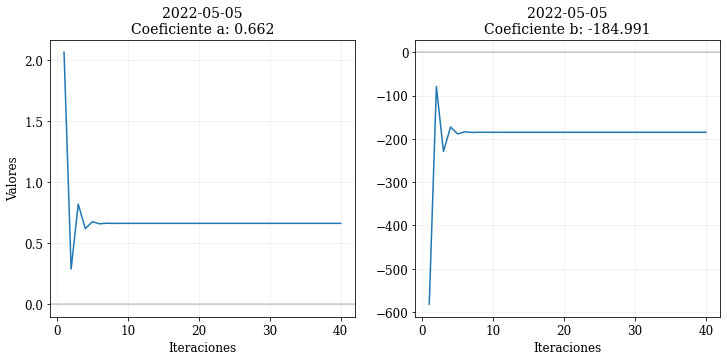


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,16.772729,0.735566,1.375359,0.354931,666.934005,51.563698,558.247555,259.804950,259.804950,9.072212
mean,13.488595,0.465731,0.537489,0.185411,592.571725,38.910232,423.217515,130.443977,130.511302,4.563733
median,13.390339,0.470679,0.535229,0.176635,598.343696,38.826728,423.530199,136.984654,136.984654,4.779287
min,11.324142,0.219831,0.024216,0.086725,447.456837,28.512712,306.262323,-23.913329,0.000000,-0.839399
mode,13.296277,0.490262,0.480464,0.174799,605.508442,37.431889,429.402248,140.956556,140.956556,5.032870
stdDev,0.659432,0.091834,0.193430,0.034874,31.179293,3.061655,28.762008,44.883197,44.676095,1.569117


Procesando imagen 2022-05-21 lai_method = 1


coef a: 0.15487366085805226
coef b: -39.959795429627654



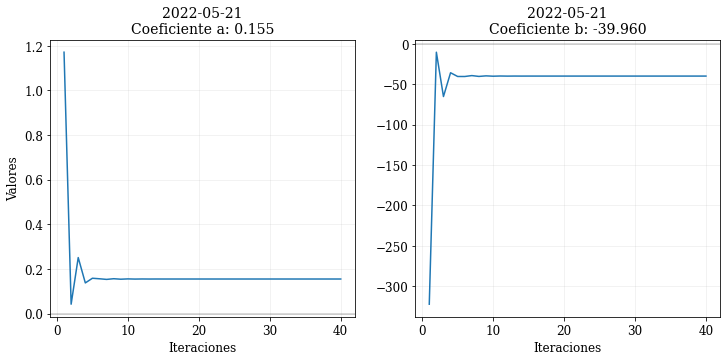


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,21.636364,0.630858,0.873427,0.269788,617.379177,61.238493,456.518071,182.299550,182.299550,6.400555
mean,18.717004,0.317700,0.240279,0.194326,540.709092,52.236857,394.529957,93.942278,93.942278,3.302945
median,18.791610,0.297891,0.212844,0.193725,540.584074,52.695201,393.751612,94.550533,94.550533,3.327453
min,15.436159,0.141125,0.000000,0.117835,476.566064,37.233883,371.765202,11.972215,11.972215,0.421874
mode,19.110583,0.276203,0.189430,0.186049,538.543546,52.324038,394.732145,98.437855,98.437855,3.452918
stdDev,0.990592,0.065664,0.105948,0.023458,23.473325,3.300488,10.653768,29.430085,29.430085,1.032668


Procesando imagen 2022-06-14 lai_method = 1


coef a: 0.17525903439023685
coef b: -47.47679071366877



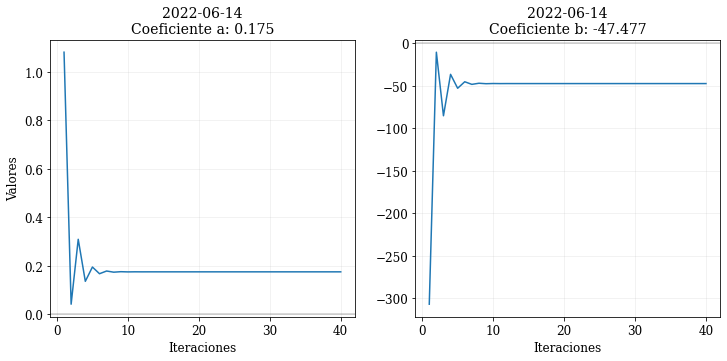


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,31.941223,0.564996,0.687171,0.288800,565.680242,80.868925,436.150900,125.578102,125.578102,4.442088
mean,28.682088,0.264333,0.155165,0.177533,491.227967,71.215703,400.455609,19.556655,24.136111,0.693608
median,28.299108,0.278310,0.181641,0.179164,491.444712,70.830053,396.781229,21.498525,21.718503,0.765610
min,24.142331,0.085178,0.000000,0.085746,400.482053,55.541898,368.251871,-90.203779,0.000000,-3.209548
mode,30.515539,0.286231,0.000111,0.187987,480.445381,69.195196,385.779395,27.497733,0.002881,1.016371
stdDev,1.628483,0.089286,0.128500,0.037168,27.283048,4.161852,16.856254,28.865602,21.120151,1.024410


,coef_a,coef_b
13-Ene,0.156781,-40.258440
29-Ene,0.385038,-105.550145
10-Mar,0.942560,-276.192962
03-Abr,0.834987,-234.670572
05-May,0.661706,-184.991231
21-May,0.154874,-39.959795
14-Jun,0.175259,-47.476791


In [6]:
# =============================================================
# Inputs iniciales
# =============================================================

# En caso de guardar los arcchivos
save_files = True
ruta_base = os.getcwd() # A esta se anexará
carpeta_output = 'comprobacion' # 'output2'

elev_station = 2.9 # m
n_iteraciones = 40 # <-- Establecer cantidad de iteraciones

lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

# =============================================================
# Datos de estación: Velocidad de viento y ET
list_weather_st = [
    [1.6*3.6, 0.13], # 0 '2022-01-13' 1.6
    [1.6*3.6, 0.15], # 1 '2022-01-29'
    [3.2*3.6, 0.20], # 2 '2022-03-10' 3.2 (original)
    [3.2*3.6, 0.17], # 3 '2022-04-03' 1.6
    [3.2*3.6, 0.20], # 4 '2022-05-05'
    [1.6*3.6, 0.20], # 5 '2022-05-21'
    [1.6*3.6, 0.16]  # 6 '2022-06-14' (original)
] # km/h

# Coordenadas previamente seleccionados (Pixel Frio)
# pixeles ndvi-albedo
list_coords_pixf = [
    [-79.775487, -6.601604], # 0 '2022-01-13' n1: 50 n2: 10
    [-79.785809, -6.598078], # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984], # 2 '2022-03-10' n1: 50 n2: 5  [-79.782536, -6.601574]
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10  [-79.782545, -6.601342]
    [-79.778744, -6.604585], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778718, -6.604593], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778739, -6.604574], # 6 '2022-06-14' n1: 50 n2: 5
]

# Coordenadas previamente seleccionados (Pixel Caliente)
# Pixeles ndvi-albedo 
list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.778464, -6.605114],  # 1 '2022-01-29' n1: 50 n2: 10 
    [-79.777924, -6.604045],  # 2 '2022-03-10' n1: 50 n2: 5 [-79.778736, -6.604317]
    [-79.778468, -6.603759],  # 3 '2022-04-03' n1: 80 n2: 10
    [-79.784448, -6.598642],#[-79.782006, -6.598379],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-79.785537, -6.598398],#[-79.78228, -6.596453],   # 5 '2022-05-21' n1: 50 n2: 10
    [-79.784729, -6.595629]#[-79.784462, -6.59621],   # 6 '2022-06-14' n1: 50 n2: 5
]

# =============================================================
# Procesamiento
# =============================================================

lista_imgprocesadas_ET = [] # Lista vacía que almacenará resultados

for index in range(n_imgs):

    # Selección de datos
    img_seleccionada = lista_imgprocesadas[index]
    img_productos = img_seleccionada['img_productos']
    d2 = img_seleccionada['d2']
    fecha = img_seleccionada['fecha']

    print(f'Procesando imagen {fecha} lai_method = {lai_method}\n')
    
    # Generar estadísticas y guardar en DataFrame
    img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
    img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')

    # =============================================================
    # 1. Establecer valores de pixel frío y caliente
    # Selección de datos mediante el'index'
    # =============================================================

    filtrado_ws, filtrado_et = list_weather_st[index]

    pixf_coord = list_coords_pixf[index]
    pixf_ee_coord = ee.Geometry.Point(pixf_coord)
    pix_f_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

    pixc_coord = list_coords_pixc[index]
    pixc_ee_coord = ee.Geometry.Point(pixc_coord)
    pix_c_values = get_pixel_values(pixc_ee_coord, d2, img_productos)

    # Valores obtenidos por get_pixel_values
    pd.DataFrame.from_dict({'PixF': pix_f_values, 'PixC': pix_c_values}, 
                           orient='columns').to_csv(f'output/{fecha}_pixeles_selec.csv')
        
    # =============================================================
    # 2. Flujo de calor sensible H - Proceso Iterativo
    # =============================================================
    resultados_f, resultados_c = parte_iterativa(n_iteraciones,
                                                 elev_station,
                                                 pix_f_values, pix_c_values, 
                                                 filtrado_ws, filtrado_et)

    resultados_f_df = pd.DataFrame(resultados_f)
    resultados_c_df = pd.DataFrame(resultados_c)

    # Guardar dataframe
    resultados_f_df.to_csv(f'output/{fecha}_iteraciones_pixf.csv')
    resultados_c_df.to_csv(f'output/{fecha}_iteraciones_pixc.csv')
    
    # columnas = ['u*', 'r_ah', 'air_dens_p', 'dT0', 'dT1', 'H1', 'a_coef', 'b_coef', 'L', 'y200m', 'yhz2', 'yhz1']
    # display(resultados_c_df) # resultados_c_df[columnas]

    # Coeficientes a y b finales de selección de pixeles frío y caliente
    coef_a = resultados_f[-1]['a_coef']
    coef_b = resultados_f[-1]['b_coef']
    print(f'\ncoef a: {coef_a}\ncoef b: {coef_b}\n')

    # Gráfica 1x2 
    grafica_coefs(resultados_f_df, fecha, coef_a, coef_b, save_files=save_files)

    # =============================================================
    # 3. Componentes de balance de energía
    # =============================================================

    # 1. Rn
    R_n = img_seleccionada['img_Rn']
    img_Rn = R_n.select('R_n').clip(predios_agricolas)

    # 2. G
    img_tempK = img_productos.select('Ts_k')
    img_G = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                                 {'Ts_K': img_tempK,
                                  'albedo': img_productos.select('albedo'),
                                  'NDVI': img_productos.select('NDVI')}
                                ).multiply(R_n.select('R_n'))

    # 3. H
    img_H = get_H_corregido(img_productos, resultados_c, dem, elev_station)
    img_H_stats = get_stats(img_H, predios_agricolas, 30)
    # display(img_H_stats)

    # =============================================================
    # 4. Balance de energía: LE = Rn - G - H
    # Si H es superior a Rn, se producirán valores negativos de LE
    # =============================================================
    img_LE = img_Rn.expression('Rn - G - H',
                               {'Rn': img_Rn,
                                'G': img_G,
                                'H': img_H})

    # Filtrando valores negativos
    # img_LE_gt0 = img_LE.updateMask(img_LE.gt(0)) # Recorta
    img_LE_gt0 = img_LE.where(img_LE.lte(0), 0) # Filtra
    
    # Unir los componentes en una sola imagen
    img_compbalance = ee.Image([img_Rn, img_G, img_H, img_LE, img_LE_gt0]).rename(['0_Rn', '1_G', '2_H', '3_LE', '3_LE_vis'])
    img_compbalance_stats = get_stats(img_compbalance, predios_agricolas, 30)
    img_compbalance_stats_df = pd.DataFrame.from_dict(img_compbalance_stats, orient='index', dtype='float') # .round(3)

    # =============================================================
    # 5. Evapotranspiración del cultivo ETinst (mm/hr y mm/d)
    # =============================================================

    # ET (mm/hr)
    img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts':img_tempK}).rename('lambda')
    img_ET_inst = img_LE.expression('3600*img_LE/lambda', {'img_LE': img_LE,'lambda': img_lambda}).rename('ET')

    # ET (mm/día)
    img_ET_inst = img_ET_inst.multiply(24) # mm/hr * 24 hrs/dia = mm/dia

    # Generar estadísticas y guardar en dataframe
    img_ET_inst_stats = get_stats(img_ET_inst, predios_agricolas, 30)
    img_ET_inst_stats_df = pd.DataFrame.from_dict(img_ET_inst_stats, orient='index', dtype='float')#.round(3)

    # =============================================================
    # 6. Resultados
    # =============================================================

    # Generar dataframe final
    lista_dfs = [
        img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']], 
        img_compbalance_stats_df, 
        img_ET_inst_stats_df
    ]
    df_stats = pd.concat(lista_dfs, axis=1)

    # Visualización de resultados para comprobación
    print('\nResultados:')
    display(df_stats)

    # # Guardar dataframe final
    # if save_files == True:
    #     nombre_csv = f'{fecha}_Resultados.csv'
    #     df_stats.to_csv(os.path.join(ruta_base, carpeta_output, nombre_csv))
    
    # Unir imagenes de componentes y ET procesadas en una lista
    img_seleccionada['img_CompBalance'] = img_compbalance # ee.Image
    img_seleccionada['img_ETinst'] = img_ET_inst    # ee.Image
    img_seleccionada['stats'] = df_stats            # dataframe
    img_seleccionada['pix_f'] = resultados_f_df     # df (f de frío)
    img_seleccionada['pix_c'] = resultados_c_df     # df (c de caliente)
    img_seleccionada['pixeles'] = {'coef_a':coef_a, 'coef_b':coef_b} 
    
    # Finalmente agregamos cada imagen procesada a una lista
    lista_imgprocesadas_ET.append(img_seleccionada)

# Coeficientes finales
tabla_coefs(lista_imgprocesadas_ET, n_imgs, lista_fechas)
# lista_imgprocesadas_ET[index]['stats'] # Para ver los datos de las iteraciones por imagen

### Revisar tabla de rangos

In [40]:
# Tabla de rangos
def rangos(index, variable):
    rangos_valores = f"{lista_imgprocesadas_ET[index]['stats'][variable]['mean']:.3f} ({lista_imgprocesadas_ET[index]['stats'][variable]['min']:.3f} - {lista_imgprocesadas_ET[index]['stats'][variable]['max']:.3f})"
    return rangos_valores

lista_nombres = ['NDVI', 'LAI', 'Albedo', 'Rn (W m-2)', 'G (W m-2)', 'H (W m-2)', 'ETc (mm d-1)']
lista_variables = ['NDVI', 'LAI', 'albedo', '0_Rn', '1_G', '2_H', 'ET']
lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

# Armar cuadro estadístico x(min-max)
lista_resultados = []

for index in range(n_imgs):
    
    result_int = []
    for variable in lista_variables:
        valores = rangos(index, variable)
        result_int.append(valores)
        
    dict_result = {f"{lista_fechas[index]}": result_int}
    df = pd.DataFrame(data=dict_result, index=lista_nombres)
    
    lista_resultados.append(df)

# Unir dfs en uno solo
df_resultados = pd.concat(lista_resultados, axis=1)
# df_resultados.to_csv('df_resultados.csv')
df_resultados

,13-Ene,29-Ene,10-Mar,03-Abr,05-May,21-May,14-Jun
NDVI,0.174 (-0.148 - 0.638),0.354 (0.039 - 0.759),0.695 (0.058 - 0.813),0.681 (0.242 - 0.769),0.466 (0.220 - 0.736),0.318 (0.141 - 0.631),0.264 (0.085 - 0.565)
LAI,0.046 (0.000 - 0.922),0.204 (0.000 - 1.619),1.005 (0.000 - 1.824),1.053 (0.048 - 1.522),0.537 (0.024 - 1.375),0.240 (0.000 - 0.873),0.155 (0.000 - 0.687)
Albedo,0.109 (0.061 - 0.185),0.105 (0.055 - 0.194),0.143 (0.043 - 0.188),0.160 (0.095 - 0.195),0.185 (0.087 - 0.355),0.194 (0.118 - 0.270),0.178 (0.086 - 0.289)
Rn (W m-2),686.111 (596.081 - 772.329),700.365 (619.665 - 769.894),639.913 (585.681 - 735.946),659.103 (613.085 - 730.212),592.572 (447.457 - 666.934),540.709 (476.566 - 617.379),491.228 (400.482 - 565.680)
G (W m-2),64.064 (51.981 - 82.277),53.887 (35.003 - 67.893),59.258 (45.233 - 89.602),37.548 (30.543 - 58.651),38.910 (28.513 - 51.564),52.237 (37.234 - 61.238),71.216 (55.542 - 80.869)
H (W m-2),468.905 (438.533 - 578.031),558.683 (503.307 - 739.566),581.853 (478.498 - 978.080),632.601 (535.956 - 939.032),423.218 (306.262 - 558.248),394.530 (371.765 - 456.518),400.456 (368.252 - 436.151)
ETc (mm d-1),5.392 (-0.649 - 8.867),3.083 (-5.262 - 6.803),-0.043 (-16.180 - 5.336),-0.388 (-12.609 - 4.369),4.564 (-0.839 - 9.072),3.303 (0.422 - 6.401),0.694 (-3.210 - 4.442)


### Revisar imagenes

In [10]:
get_stats(Ts_dem, predios_agricolas, 30)

{'max': {'Ts_k': 305.36487286879725},
 'mean': {'Ts_k': 302.1130275605323},
 'median': {'Ts_k': 301.70086780486656},
 'min': {'Ts_k': 297.56598075457583},
 'mode': {'Ts_k': 300.6386654882428},
 'stdDev': {'Ts_k': 1.626703868351111}}

In [15]:
get_stats(img_dT, predios_agricolas, 30)

{'max': {'dT': 12.026943097944056},
 'mean': {'dT': 10.77485899463043},
 'median': {'dT': 10.615225002301734},
 'min': {'dT': 9.024073061397047},
 'mode': {'dT': 10.210838289210285},
 'stdDev': {'dT': 0.6263428488243965}}

In [17]:
get_stats(air_pressureP, predios_agricolas, 30)

{'max': {'constant': 100.82830832229618},
 'mean': {'constant': 100.75613845328498},
 'median': {'constant': 100.75770825535405},
 'min': {'constant': 100.66363711640493},
 'mode': {'constant': 100.76947215205384},
 'stdDev': {'constant': 0.024090406369826903}}

In [18]:
get_stats(air_dens_p, predios_agricolas, 30)

{'max': {'air_dens': 1.2060642042527694},
 'mean': {'air_dens': 1.1942541404650158},
 'median': {'air_dens': 1.1951444428962048},
 'min': {'air_dens': 1.1862133996762003},
 'mode': {'air_dens': 1.197318729007931},
 'stdDev': {'air_dens': 0.004087849553484041}}

In [16]:
air_pressureP = dem.expression(
    '101.3*( (293.15-0.0065*dem_elev)/293.15)**5.26',
    {'dem_elev': dem})

air_dens_p = air_pressureP.expression(
    '1000*air_pressureP/(1.01*(air_tempK)*287)',
    {'air_pressureP': air_pressureP,
     'air_tempK': img_tempK.subtract(img_dT)}).rename('air_dens')


In [14]:
img_tempk = lista_imgprocesadas[n_img]['img_productos'].select('Ts_k')
Ts_dem = img_tempK.expression('img_tempK + Tlapse_rate/1000*(dem_elev-elev_station)',
                              {'img_tempK': img_tempK,
                               'Tlapse_rate': 6.5,
                               'dem_elev': dem,
                               'elev_station': elev_station})
pixeles = lista_imgprocesadas_ET[n_img]['pixeles']

# img_dT = b + a*Ts_dem
img_dT = Ts_dem.expression('b + a*Ts_dem',
                           {'a': pixeles['coef_a'], 'b': pixeles['coef_b'], 'Ts_dem': Ts_dem}).rename('dT')

In [9]:


# lista_imgprocesadas_ET[n_img]['img_CompBalance']

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(Ts_dem, {}, 'ts_dem')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [16]:
lista_imgprocesadas[3]['d2'].getInfo()

1.0004262213577246

In [7]:
# Visualizar imágenes

# 0 '2022-01-13'
# 1 '2022-01-29'
# 2 '2022-03-10'
# 3 '2022-04-03'
# 4 '2022-05-05'
# 5 '2022-05-21'
# 6 '2022-06-14'

n_img = 0

# Mapas a visualizar
img_temp = lista_imgprocesadas[n_img]['img_productos'].select('Ts_c')
img_rgb = lista_imgprocesadas[n_img]['img_toa'].clip(predios_bound)
fecha = lista_imgprocesadas[n_img]['fecha']
img_albedo = lista_imgprocesadas[n_img]['img_productos'].select('albedo')
img_lai = lista_imgprocesadas[n_img]['img_productos'].select('LAI')

print(fecha)

img_H = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('2_H')
img_Rn = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('0_Rn')
img_le = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('3_LE_vis')

img_ndvi = lista_imgprocesadas[n_img]['img_productos'].select('NDVI')

# Seleccionar imagen ET
img_ET = lista_imgprocesadas_ET[n_img]['img_ETinst']
img_ETpos = img_ET.updateMask(img_ET.gte(0))
img_ETnega = img_ET.updateMask(img_ET.lt(0))

img_albedo_rangos = img_albedo.updateMask(img_albedo.gte(0.17))

# Parámetros de visualización
paleta_ET = ["F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"]

vis_params_ndvi = {'min': 0,#lista_imgprocesadas_ET[n_img]['stats']['NDVI']['min'],
                   'max': 1,#lista_imgprocesadas_ET[n_img]['stats']['NDVI']['max'],
                   'palette': ndvi_cmap}

vis_params_lai = {
    'min': 0,
    'max': 2,
    'palette': ndvi_cmap#cmp.get_palette('gray') 
}
vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': ndvi_cmap#cmp.get_palette('gray') 
}
vis_params_alb_rangos = {
    'min': 0.17,
    'max': 0.25,
    'palette': ndvi_cmap #cmp.get_palette('gray') 
}

vis_paramsp = {'min': 0, 
               'max': 10, 
               # 'max': int(max_et), 
               'palette': paleta_ET} #cmp.get_palette('Grays')} 

vis_paramset = {'min': 0, 
               'max': 10, 
               # 'max': int(max_et), 
               'palette': paleta_ET} #cmp.get_palette('Grays')}

vis_paramsn = {'min': lista_imgprocesadas_ET[n_img]['stats']['ET']['min'],  
               'max': 0, 
               'palette': cmp.get_palette('Reds_r')} 

vis_paramst = {'min': lista_imgprocesadas_ET[n_img]['stats']['Ts_c']['min'],  
               'max': lista_imgprocesadas_ET[n_img]['stats']['Ts_c']['max'], 
               'palette': cmp.get_palette('RdYlBu_r')}  # YlGnBu

vis_params_le = {'min': lista_imgprocesadas_ET[n_img]['stats']['3_LE_vis']['min'],  
                 'max': lista_imgprocesadas_ET[n_img]['stats']['3_LE_vis']['max'], 
                 'palette': ndvi_cmap}#cmp.get_palette('RdYlBu_r')}  # YlGnBu

vis_params_H = {'min': lista_imgprocesadas_ET[n_img]['stats']['2_H']['min'], 
                'max': lista_imgprocesadas_ET[n_img]['stats']['2_H']['max'], 
                'palette': cmp.get_palette('Grays')}

display(lista_imgprocesadas_ET[n_img]['stats'])

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')

Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_albedo, vis_params_alb, 'albedo')
Map.addLayer(img_lai, vis_params_lai, 'lai')

Map.addLayer(img_ET, vis_paramset, 'img_ET')
Map.addLayer(img_ETpos, vis_paramsp, 'img_ETpos')
Map.addLayer(img_ETnega, vis_paramsn, 'img_ETnega')

Map.addLayer(img_H, vis_params_H, 'img_H')
Map.addLayer(img_le, vis_params_le, 'img_le')
Map.addLayer(img_temp, vis_paramst, 'img_temp')

# Map.addLayer(img_albedo_rangos, vis_params_alb_rangos, 'albedo_gt17')

# Prueba: Selección de pixeles
# Map.addLayer(ee.Geometry.Point(list_coords_pixf1[n_img]), {}, 'Pixel F anterior')
# Map.addLayer(ee.Geometry.Point(list_coords_pixf[n_img]), {}, 'Pixel F')
# Map.addLayer(ee.Geometry.Point(list_coords_pixc1[n_img]), {}, 'Pixel C anterior')
# Map.addLayer(ee.Geometry.Point(list_coords_pixc[n_img]), {}, 'Pixel C')

# Map.addLayer(ee.Geometry.Point(), {}, 'Pixel C final')

Map.add_colorbar(vis_paramset, orientation='horizontal') #, label='ET')
Map

2022-01-13


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,26.066006,0.638488,0.922158,0.185254,772.328767,82.277447,578.031242,251.982392,251.982392,8.867080
mean,20.426264,0.173787,0.045677,0.108548,686.110537,64.064258,468.905068,153.141211,153.173034,5.392227
median,19.968177,0.154227,0.000028,0.105683,687.494991,63.070315,463.461803,163.369398,162.708563,5.722259
min,17.866862,-0.147715,0.000000,0.060872,596.081181,51.980854,438.532979,-18.395543,0.000000,-0.648556
mode,19.529479,0.126766,0.000028,0.084238,696.470801,62.051227,457.485348,174.871352,174.470390,6.152229
stdDev,1.565740,0.121992,0.104066,0.026230,29.253303,4.916764,19.228541,48.402281,48.296241,1.700371


Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')
Map.addLayer(img_H, vis_params_H, 'img_H')
Map.addLayer(img_ETnega, vis_paramsn, 'img_ETnega')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
Map.user_rois.geometry().coordinates().getInfo() 

[-79.776576, -6.602948]

### Gráficas

In [7]:
lista_fechas

['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

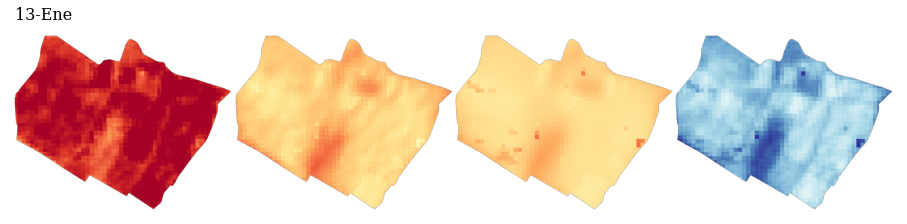

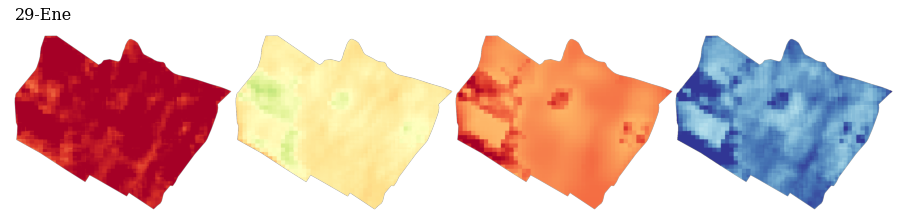

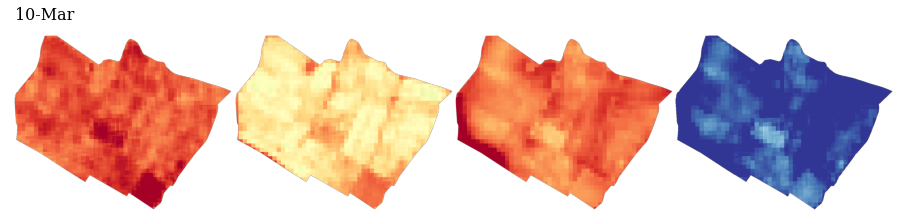

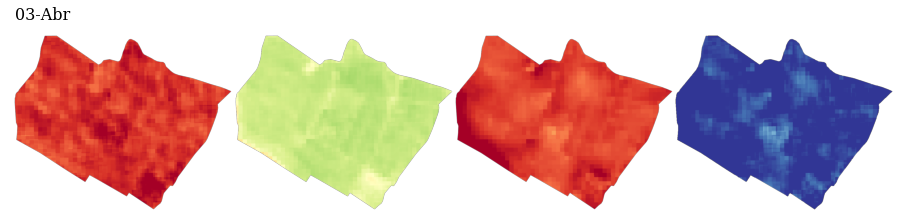

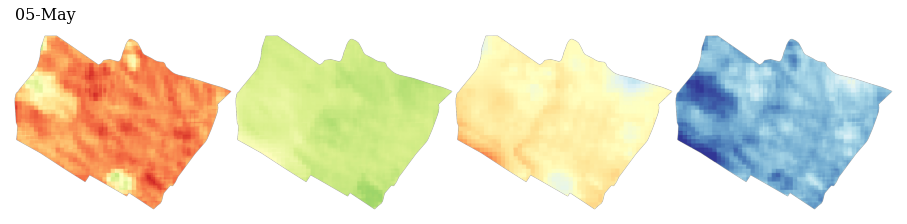

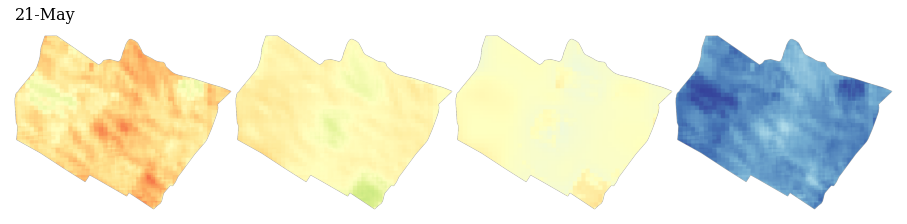

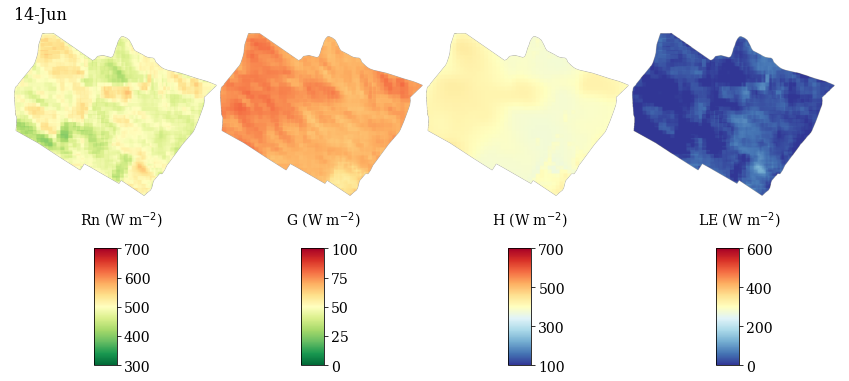

In [21]:
vis_Rn = {'min': 300, # img_final_stats['min']['0_Rn'],
          'max': 700, #img_final_stats['max']['0_Rn'],
          'palette': cmp.get_palette('RdYlGn_r')}

vis_G = {'min': 0,   # img_final_stats['min']['1_G'],
         'max': 100, # img_final_stats['max']['1_G'],
         'palette': cmp.get_palette('RdYlGn_r')}

vis_H = {'min': 100,   # img_final_stats['min']['2_H'],
         'max': 700, # img_final_stats['max']['2_H'],
         'palette': cmp.get_palette('RdYlBu_r')}

vis_LE = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 600, # img_final_stats['max']['3_LE'],
          'palette': cmp.get_palette('RdYlBu_r')}

# Listas para iteraciones 
lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '14-Jun']
lista_paletas = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W m$^{-2}$)', 'G (W m$^{-2}$)', 'H (W m$^{-2}$)', 'LE (W m$^{-2}$)'] 

save_filename = True # None para no guardar, True u otra cosa para guardar

for index in range(n_imgs):
    
    # Selección de imagenes Landsat: 0 1 Enero, 2 Marzo, 3 Junio
    img_productos = lista_imgprocesadas_ET[index]['img_CompBalance'] # <-- Cambiar por cada grafica
    
    # --------------------------------------------------------------------
    # Elaboración de gráfica
    # --------------------------------------------------------------------
    
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Fecha ubicado a la izquierda
    axs[0].text(-79.7872, -6.594549+2*extent, lista_fechas[index], fontsize=16) 
    
    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.325 # 0.125
    dims = 1000    
    
    extent1 = -79.78719338866794+9*extent
    extent2 = -6.605665317455976-4*extent
    
    if index != (n_imgs-1):
        
        for i in range(4):
            cartoee.add_layer(axs[i], 
                              img_productos.select(lista_variables[i]), 
                              dims=dims, 
                              region=zoom_region, 
                              vis_params= lista_paletas[i]) # lista_vispaletas conjunto de vis
            axs[i].axis('off')

    else:
        
        # 1. Rn
        cartoee.add_layer(axs[0], img_productos.select(lista_variables[0]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[0])
        cartoee.add_colorbar(axs[0], vis_params=lista_paletas[0], loc='right', tick_font_size=14,
                             posOpts=[0.2, bottom, width, height])                        
        axs[0].text(extent1, extent2, lista_etiquetas[0], fontsize=14)
        axs[0].axis('off')
        
        # 2. G
        cartoee.add_layer(axs[1], img_productos.select(lista_variables[1]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[1])
        cartoee.add_colorbar(axs[1], vis_params=lista_paletas[1], loc='right', tick_font_size=14,
                             posOpts=[0.38, bottom, width, height])
        axs[1].text(extent1, extent2, lista_etiquetas[1], fontsize=14)
        axs[1].axis('off')
        
        # 3. H
        cartoee.add_layer(axs[2], img_productos.select(lista_variables[2]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[2])
        cartoee.add_colorbar(axs[2], vis_params=lista_paletas[2], loc='right', tick_font_size=14,
                             posOpts=[0.56, bottom, width, height],
                             ticks=[100, 300, 500, 700]) # <-- Asignación de ticks para H
        axs[2].text(extent1, extent2, lista_etiquetas[2], fontsize=14)
        axs[2].axis('off')
        
        # 4. LE
        cartoee.add_layer(axs[3], img_productos.select(lista_variables[3]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[3])
        cartoee.add_colorbar(axs[3], vis_params=lista_paletas[3], loc='right', tick_font_size=14,
                             posOpts=[0.74, bottom, width, height],
                             ticks=[0, 200, 400, 600]) # <-- Asignación de ticks para LE
        axs[3].text(extent1, extent2, lista_etiquetas[3], fontsize=14)
        axs[3].axis('off')
    
    # Guardar
    if save_filename is not None:
        img_name = f'output/Balance_Fecha-{index}.png'
        plt.savefig(img_name, bbox_inches='tight', pad_inches=.1) #, dpi=400);
    
    plt.show()

### Gráficas 1x1

In [ ]:
# Generar gráficas de variables determinadas
# ['NDVI',  'SAVI', 'LAI', 'albedo', 'Ts_k', 'Ts_c', 't_sw', 'e_0', 'e_NB', 'cos_theta', 'cos_theta_1', 'slope', 'elevation']
for n_img, img in enumerate(lista_imgprocesadas):

    # img_rgb_sr = img['img_SR']
    img_ = img['img_productos'].select('NDVI')
    fecha = img['fecha']

    vis_params_ndvi = {'min': 0,
                       'max': 1,
                       'palette': ndvi_cmap}
    
    # vis_params_sr = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.3, 'gamma':1.3}
    vis_params_alb = {
        'min': 0,
        'max': 0.25,
        'palette': ndvi_cmap#cmp.get_palette('gray') 
    }
    
    title_map = f'{fecha} - NDVI'
    
    get_grafica_cartoee_color(img_.clip(predios_agricolas).blend(predios_vis), 
                                  vis_params_ndvi,                              
                                  text=None, 
                                  title_map=title_map,
                                  label='NDVI', 
                                  save_fig=f'{fecha}_NDVI',
                                  nogrid=True)

### Gráfica ET

In [10]:
lista_imgprocesadas_ET[0]['img_ETinst']

{'type': 'Image',
 'bands': [{'id': 'ET',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [319, 414],
   'origin': [4465, 1421],
   'crs': 'EPSG:32617',
   'crs_transform': [30, 0, 494085, 0, -30, -683685]}]}

In [11]:
# Preparamos una lista con imagenes de ET

# 0 '2022-01-13'
# 1 '2022-01-29'
# 2 '2022-03-10'
# 3 '2022-04-03'
# 4 '2022-05-05'
# 5 '2022-05-21'
# 6 '2022-06-14'

lista_et = []
# for i in range(4):
for i in range(n_imgs): # (3, n_imgs)
    lista_et.append(lista_imgprocesadas_ET[i]['img_ETinst']) # Banda 'ET'
pprint(lista_et)

# Convertimos la lista de imagenes en una sola con cada elemento como banda
img_ET_final = ee.Image(lista_et) # Asigna el sufijo _# dependiendo del número de bandas comenzando desde el segundo con _1
img_ET_final.bandNames().getInfo()

['ET', 'ET_1', 'ET_2', 'ET_3', 'ET_4', 'ET_5', 'ET_6']

#### Gráfica ET 1x7

C:\Users\USUARIO\anaconda3\envs\gee\lib\site-packages\geemap\cartoee.py:407: UserWarning: discrete keyword used when "palette" key is supplied with visParams, creating a continuous colorbar...
  warnings.warn(


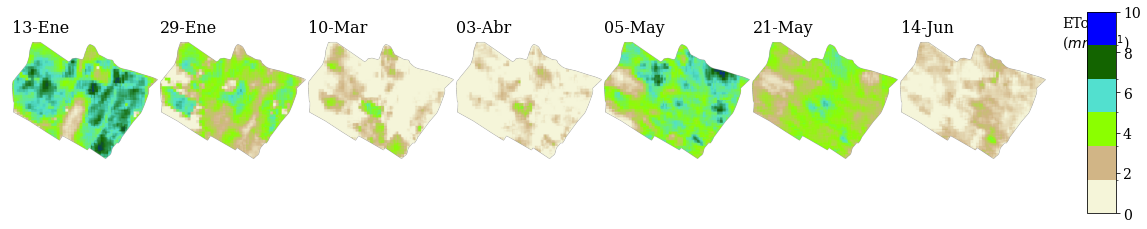

In [12]:
# --------------------------------------------------------------------
# Elaboración de gráfica de ET con 4 columnas y 1 fila
# Requisito: Tener las 4 imagenes de ET guardadas en una lista
# --------------------------------------------------------------------
# Parámetros previos
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '14-Jun']
lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May','14-Jun']
# lista_fechas = ['03-Abr', '05-May', '21-May', '14-Jun'] # <------------
imgs_ET = lista_et

# Parametros de visualización
# paleta_ET = cmp.get_palette('RdYlGn_r')
# paleta_ET.insert(0, 'FFFFFF')
paleta_ET = ["F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"]
vis_ET = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 10, # img_final_stats['max']['3_LE'],
          'palette': paleta_ET}

# Gráfica
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(ncols=n_imgs, wspace=-0.05) 
axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

extent = 0.0005

extent1 = -79.77332525015065+3*extent
extent2 = -6.594549-extent

zoom_region = [
    -79.77332525015065+extent, -6.605665317455976-extent,
    -79.78719338866794-extent, -6.594549+extent
]

posOpts = [
    0.875, # left
    0.30,  # bottom
    0.02,  # width
    0.35   # height
]

for i in range(n_imgs):
    axs[i].text(-79.7872, -6.594549+2*extent, lista_fechas[i], fontsize=16)
    cartoee.add_layer(axs[i], imgs_ET[i], dims=1000, region=zoom_region, vis_params=vis_ET)
    axs[i].axis('off')
    
ticks = np.arange(-2, 12+1, 2)
cartoee.add_colorbar(axs[n_imgs-1], vis_params=vis_ET, loc='right', posOpts=posOpts, tick_font_size=14, ticks=ticks, discrete=True)
axs[n_imgs-1].minorticks_on()
axs[n_imgs-1].text(extent1, extent2, 'ETc\n($mm\;d^{-1}$)', fontsize=14)

# Guardar imagen
# img_name = 'output/ETinst.jpg'
# plt.savefig(img_name, bbox_inches='tight', pad_inches=.1) #, dpi=400);

plt.show()

#### Gráficas 1x1

Producir 6 imágenes como mosaico y agregar la última 

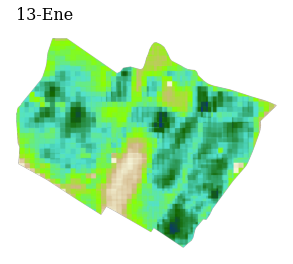

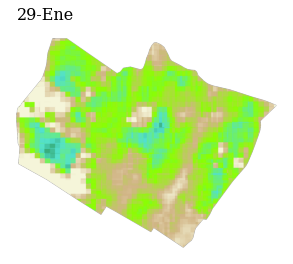

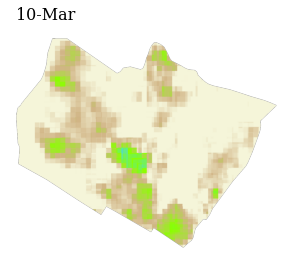

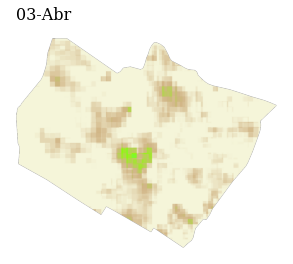

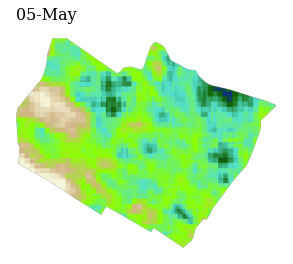

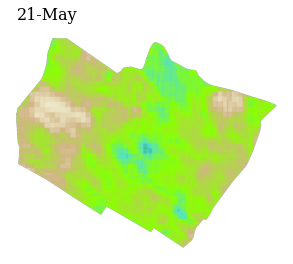

In [39]:
for i in range(n_imgs-1):
    get_grafica_cartoee_color(imgs_ET[i], 
                              vis_ET,      
                              figsize=(5,5),
                              text=lista_fechas[i], 
                              title_map=None,
                              # label='ETc (mm d-1)', 
                              save_fig=f"ET_{lista_imgprocesadas[i]['fecha']}",
                              nogrid=True,
                              scale_bar=None)

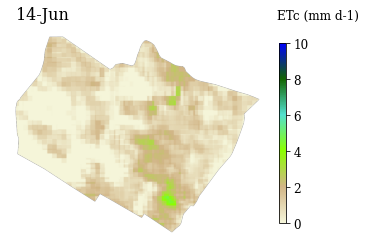

In [38]:
get_grafica_cartoee_color(imgs_ET[n_imgs-1], 
                          vis_ET,      
                          figsize=(5,5),
                          text=lista_fechas[n_imgs-1], 
                          title_map=None,
                          label='ETc (mm d-1)', 
                          save_fig=f"ET_{lista_imgprocesadas[n_imgs-1]['fecha']}",
                          nogrid=True,
                          scale_bar=None)